### Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу

In [1]:
from IPython.display import clear_output
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148 
!unzip -q 10256148
clear_output()

In [2]:
import timit_utils as tu
import os
import librosa
import numpy as np
import random
import time
import math
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
BASE_DIR = Path('/content/drive/MyDrive/')

Mounted at /content/drive/


## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

In [4]:
class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):

        self.range_tr1=self.range_tr2=self.range_tr3=self.range_v1=self.range_v2=self.range_v3=self.range_tt1=self.range_tt2=self.range_tt3=0

        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        #print(self.id_age_dict)
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, mode, age_mode=True))
              except:
                  print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        if mode == 'train':
          print('\nБаланс классов по возрастам (Train) - 0-25:',self.range_tr1,', 25-40:',self.range_tr2,', 40+:',self.range_tr3,'\n')
        if mode == 'valid':
          print('\nБаланс классов по возрастам (Valid) - 0-25:',self.range_v1,', 25-40:',self.range_v2,', 40+:',self.range_v3,'\n')
        if mode == 'test':
          print('\n\nБаланс классов по возрастам (Test) - 0-25:',self.range_tt1,', 25-40:',self.range_tt2,', 40+:',self.range_tt3,'\n')

        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 <= age <= 40:
            return 1
        if age > 40:
            return 2

    def preprocess_sample(self, amplitudes, target, mode, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target = self.clasterize_by_age(target)
        
        if mode == 'train':
          if target == 0:
            self.range_tr1 +=1
          elif target == 1:
            self.range_tr2 +=1
          elif target == 2:
            self.range_tr3 +=1

        if mode == 'valid':
          if target == 0:
            self.range_v1 +=1
          elif target == 1:
            self.range_v2 +=1
          elif target == 2:
            self.range_v3 +=1

        if mode == 'test':
          if target == 0:
            self.range_tt1 +=1
          elif target == 1:
            self.range_tt2 +=1
          elif target == 2:
            self.range_tt3 +=1

        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)


class dataloader:
    def __init__(self, spectrograms, targets):
        self.data = list(zip(spectrograms, targets))

    def next_batch(self, batch_size, device):
        indices = np.random.randint(len(self.data), size=batch_size)

        input = [self.data[i] for i in indices]

        source = [line[0] for line in input]
        target = [line[1] for line in input]

        return self.torch_batch(source, target, device)

    @staticmethod
    def torch_batch(source, target, device):
        return tuple(
            [
                torch.tensor(val, dtype=torch.float).to(device, non_blocking=True)
                for val in [source, target]
            ]
        )

    @staticmethod
    def padd_sequences(lines, pad_token=0):
        lengths = [len(line) for line in lines]
        max_length = max(lengths)

        return np.array(
            [
                line + [pad_token] * (max_length - lengths[i])
                for i, line in enumerate(lines)
            ]
        )

In [5]:
_timit_dataloader = timit_dataloader()
train, valid, test = _timit_dataloader.return_data()

trainset = dataloader(*train)
validset = dataloader(*valid)
testset = dataloader(*test)

  0%|          | 0/350 [00:00<?, ?it/s]


Баланс классов по возрастам (Train) - 0-25: 580 , 25-40: 2520 , 40+: 400 



  0%|          | 0/50 [00:00<?, ?it/s]


Баланс классов по возрастам (Valid) - 0-25: 70 , 25-40: 360 , 40+: 70 



  0%|          | 0/150 [00:00<?, ?it/s]



Баланс классов по возрастам (Test) - 0-25: 230 , 25-40: 1080 , 40+: 190 



#Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


Простая сверточная сеть, ее можно дотюнить или поменять по желанию

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
print(device)
print(torch.cuda.get_device_name(device=None))

cuda:0
Tesla T4


In [ ]:
!nvidia-smi

Thu Jun 23 16:40:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.layer1 = nn.Sequential( nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128), nn.GELU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), nn.GELU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), nn.GELU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout1 = nn.Dropout(p=.4)
        self.fc1 = nn.Linear(4608, 1024)
        self.dropout2 = nn.Dropout(p=.25)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        logits = self.fc3(x)

        return logits

    def loss(self, logits, targets):
        return nn.CrossEntropyLoss()(logits.float(), targets)

In [10]:
import gc
def clear_cache(model):
  del model
  gc.collect()
  torch.cuda.empty_cache()

In [11]:
model = Model().to(device)
print(model)

Model(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_featur

In [22]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.001, amsgrad=False)

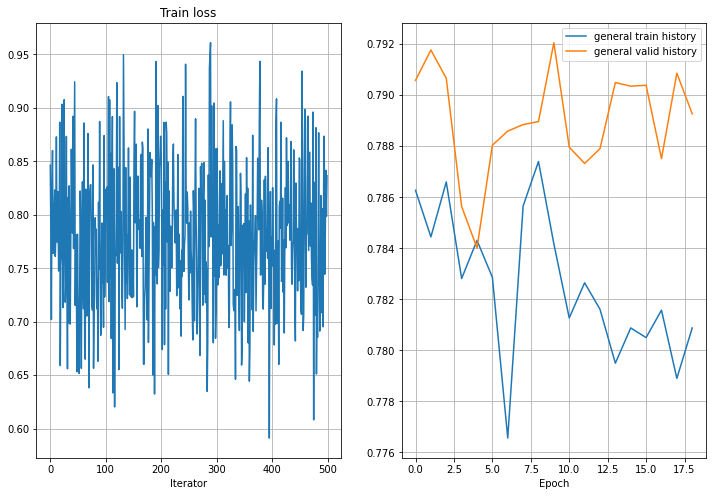

Epoch: 20 | Time: 6m 22s
	Train Loss: 0.780 | Train PPL:   2.181
	 Val. Loss: 0.791 |  Val. PPL:   2.205


In [16]:
num_epochs = 20
epoch_loss = 0
history = []
CLIP = 1

def train(model, iterator, optimizer, clip, train_history = None, valid_history = None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=2)
    model.train()
    epoch_loss = 0
    history = []
    for i, _ in enumerate(iterator):
        optimizer.zero_grad()
        inputs, target = trainset.next_batch(BATCH_SIZE, device=device)
        logits = model(inputs)
        loss = model.loss(logits, target.type(torch.LongTensor).to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step(loss)
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Iterator')
            ax[0].set_title('Train loss')
            ax[0].grid()
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.grid()
            
            plt.show()

    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, _ in enumerate(iterator):
            inputs, target = validset.next_batch(BATCH_SIZE, device=device)
            logits = model(inputs)
            loss = model.loss(logits, target.type(torch.LongTensor).to(device))
            y_pred = np.argmax(logits.detach().cpu().numpy(), axis=1) 
            valid_acc = accuracy_score(target.detach().cpu().numpy(), y_pred)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

train_history = []
valid_history = []
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
        
    train_loss = train(model, range(500), optimizer, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, range(500))
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), Path(str(BASE_DIR) + '/best-val-model.pt'))

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [20]:
best_model = Model().to(device)
best_model.load_state_dict(torch.load(Path(str(BASE_DIR) + '/best-val-model.pt')))
count = 500
test_acc = 0
for i in tqdm(range(count)):
    best_model.eval()
    with torch.no_grad():
        inputs, target = testset.next_batch(BATCH_SIZE, device=device)
        logits = best_model(inputs)
        y_pred = np.argmax(logits.detach().cpu().numpy(), axis=1) 
        acc = accuracy_score(target.detach().cpu().numpy(), y_pred)
        test_acc += acc.item()
print(f'accuracy_score:{round(test_acc/count,3)}\n')
clear_cache(best_model)

  0%|          | 0/500 [00:00<?, ?it/s]

accuracy_score:0.721



### Description:

1. Изменения в модели, относительно базового (предложенного варианта):
- добавлены слои с батч-нормализацией BatchNorm2d
- добавлены слои с регуляризацией Dropout
- добавлены линейные слои Linear
- добавлен Flatten-слой преобразования тензоров в одномерные
- заменена функция активации RELU на GELU
- модел возвращает логиты
- лосс-функция заменена на CrossEntropyLoss

2. В обучающей функции применены способы повышения точности, такие как learning rate scheduler, нормирование градиентов по максимальному значения clip. Также представлена визуализация процесса обучения, реализован механизм сохранения лучших параметров модели в зависимотси от минимальных значений валидационного лосса, рассчитано время обучения по эпохам.

2. Разбиение по возрастным классам не является сбалансированным. При этом  расширение границ мажорного класса (25-40) обеспечивает получение более высокой метрики точности, но сужает возможности более точного таргетирования.

3. Подобный классификатор мог бы использоваться для классификации людей при посещении заведений с контентом 18+ или иными возрастными ограничениями.